
# Convolutional Neural Network (CNN) Image Classifier for Persian Numbers 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[HODA dataset](http://farsiocr.ir/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%AF%D8%A7%D8%AF%D9%87/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%A7%D8%B1%D9%82%D8%A7%D9%85-%D8%AF%D8%B3%D8%AA%D9%86%D9%88%DB%8C%D8%B3-%D9%87%D8%AF%DB%8C/)<br>

HODA Daset reader from: https://github.com/amir-saniyan/HodaDatasetReader

In [2]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2

def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [3]:
# loading dataset
# train data
train_images, train_labels = read_hoda_dataset(dataset_path='data_Persian/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)
# test data
test_images, test_labels = read_hoda_dataset(dataset_path='data_Persian/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

## Visualization fucntions

In [4]:
def show_images(n,image_array,label_array, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    '''
    total_rows = math.floor(n/4)+1
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(total_rows, 4, figsize=(16, total_rows*4))
    [axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    r = 0
    c = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        #axes[r, c].set_axis_off()
        axes[r, c].imshow(np.squeeze(image), cmap=cmap)
        axes[r, c].set_title(f"Label: {label_array[i]} \n {i}th image in the dataset.")
        c += 1
        if c % 4 == 0:
            r += 1
            c = 0
    plt.show()

In [5]:
def show_images_predictions(n,image_array,label_array1,label_array2, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    the precition of class probablity distibution from each model also would be discplayed
    '''
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(n, 2, figsize=(16, n*6))
    #[axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    category_list1 = list(map(lambda x : x + 0.15, list(range(10)))) 
    category_list2 = list(map(lambda x : x - 0.15, list(range(10)))) 
    r = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        axes[r, 0].set_axis_off()
        axes[r, 0].imshow(np.squeeze(image), cmap=cmap)
        #axes[r, 1].set_title(f"{i}th image in the dataset.")
        axes[r, 1].bar(category_list1,label_array1[i], width=0.3, label='MLP')
        axes[r, 1].bar(category_list2,label_array2[i], width=0.3, label='CNN')
        axes[r, 1].set_title(f"Prediction from MLP model: {np.argmax(label_array1[i,:])} \n Prediction from CNN model: {np.argmax(label_array2[i,:])} ")
        axes[r, 1].legend()
        r += 1
    plt.show()

In [6]:
# Functions to plot accuacy and loss
def plot_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

## Check training images

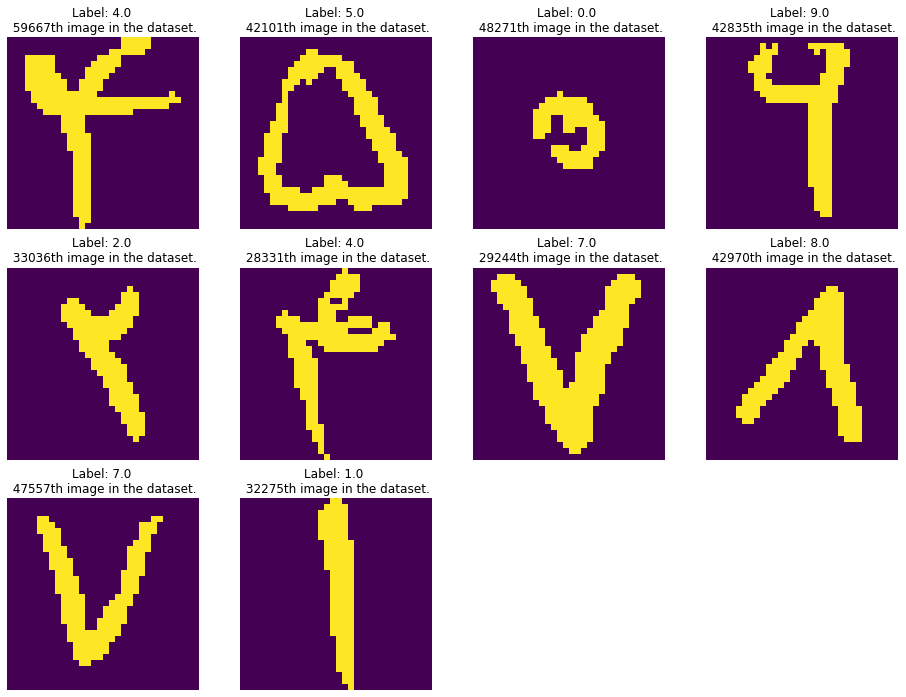

In [7]:
n = 10 # number of images to show
# showing images and correspoind labels from train set
show_images(n,train_images,train_labels)

## CNN neural network classifier

In [8]:
def CNN_NN(input_shape, dropout_rate, reg_rate):
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', input_shape=input_shape, 
               kernel_initializer="he_uniform", bias_initializer="ones", 
               kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_1_1_relu'),
        BatchNormalization(),
        Conv2D(16, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_2_2_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_1_2_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_3_3_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_2_3_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_1_4_relu'),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_2_5_relu'),
        Dense(10, activation='softmax', name='Dense_3_6_softmax')
    ])
    return model

In [9]:
def get_checkpoint_best_only(checkpoint_path):
    '''
    save best weights of the model with monitoring validation accuract
    '''
    checkpoint = ModelCheckpoint(checkpoint_path,
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    return checkpoint

In [10]:
def get_test_accuracy(model, x_test, y_test):
    '''
    checking the accuracy of the model on the test sets
    '''
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(' test accuracy: {acc:0.3f}'.format(acc=test_acc), '\n',
          'test loss: {loss:0.3f}'.format(loss=test_loss))

In [11]:
# creating CNN model for greay scale images
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-3)
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV2D_1_1_relu (Conv2D)     (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 8)         32        
_________________________________________________________________
CONV2D_2_2_relu (Conv2D)     (None, 28, 28, 16)        1168      
_________________________________________________________________
MaxPool2D_1_2_relu (MaxPooli (None, 13, 13, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
CONV2D_3_3_relu (Conv2D)     (None, 11, 11, 32)        4

In [12]:
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
checkpoint_best_only = get_checkpoint_best_only('Trained models weights_Persian\checkpoints_best_only_CNN\checkpoint')

history_CNN = model_CNN.fit(train_images,
                            train_labels,
                            batch_size=32,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Epoch 1/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.9568
Epoch 00001: val_accuracy improved from -inf to 0.98100, saving model to Trained models weights_Persian\checkpoints_best_only_CNN\checkpoint
1688/1688 [==============================] - 59s 35ms/step - loss: 0.3074 - accuracy: 0.9568 - val_loss: 0.1747 - val_accuracy: 0.9810
Epoch 2/30
1688/1688 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9858
Epoch 00002: val_accuracy improved from 0.98100 to 0.98917, saving model to Trained models weights_Persian\checkpoints_best_only_CNN\checkpoint
1688/1688 [==============================] - 74s 44ms/step - loss: 0.1406 - accuracy: 0.9858 - val_loss: 0.1132 - val_accuracy: 0.9892
Epoch 3/30
1688/1688 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9874
Epoch 00003: val_accuracy did not improve from 0.98917
1688/1688 [==============================] - 52s 31ms/step - loss: 0.1106 - accuracy: 0.9874 - v

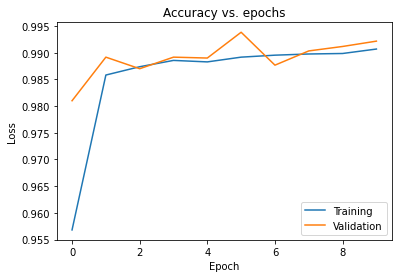

In [14]:
plot_acc(history_CNN)

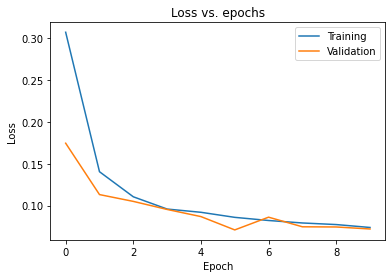

In [15]:
plot_loss(history_CNN)

In [16]:
get_test_accuracy(model_CNN, test_images, test_labels)

 test accuracy: 0.983 
 test loss: 0.097


## Model predictions

In [17]:
def get_model_best_epoch(model, checkpoint_path):
    '''
    get model saved best epoch
    '''
    model.load_weights(checkpoint_path)
    
    return model

In [18]:
# CNN model best epoch
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-4)
model_CNN = get_model_best_epoch(model_CNN, 'Trained models weights_Persian\checkpoints_best_only_CNN\checkpoint')

In [19]:
prediction_CNN = model_CNN.predict(test_images)
prediction_CNN_final = np.argmax(prediction_CNN, axis=1) # finding the maximum category
prediction_CNN_final = np.expand_dims(prediction_CNN_final, axis=1) # add the channel dimension

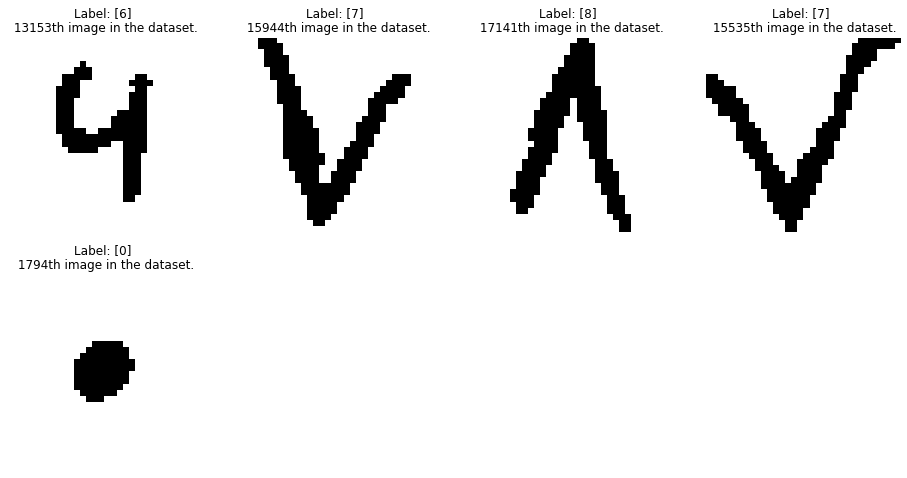

In [20]:
n = 5 # number of images to show
show_images(n,test_images,prediction_CNN_final, cmap='Greys')

## Comparison
To do a comparison between MLP and CNN model, the MLP model is created here and the trained wights are loaded

In [21]:
def MLP_NN(input_shape, reg_rate):
    '''
    Multilayer Perceptron (MLP) classification model
    '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_initializer="he_uniform", bias_initializer="ones",
              kernel_regularizer=regularizers.l2(reg_rate), name='dense_1_relu'),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_2_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_3_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_4_relu'),
        Dense(10, activation='softmax', name='dense_5_softmax')
    ])
    return model

model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP = get_model_best_epoch(model_MLP, 'Trained models weights_Persian\checkpoints_best_only_MLP\checkpoint')
prediction_MLP = model_MLP.predict(test_images)
prediction_MLP_final = np.argmax(prediction_MLP, axis=1) # finding the maximum category
prediction_MLP_final = np.expand_dims(prediction_MLP_final, axis=1) # add the channel dimension

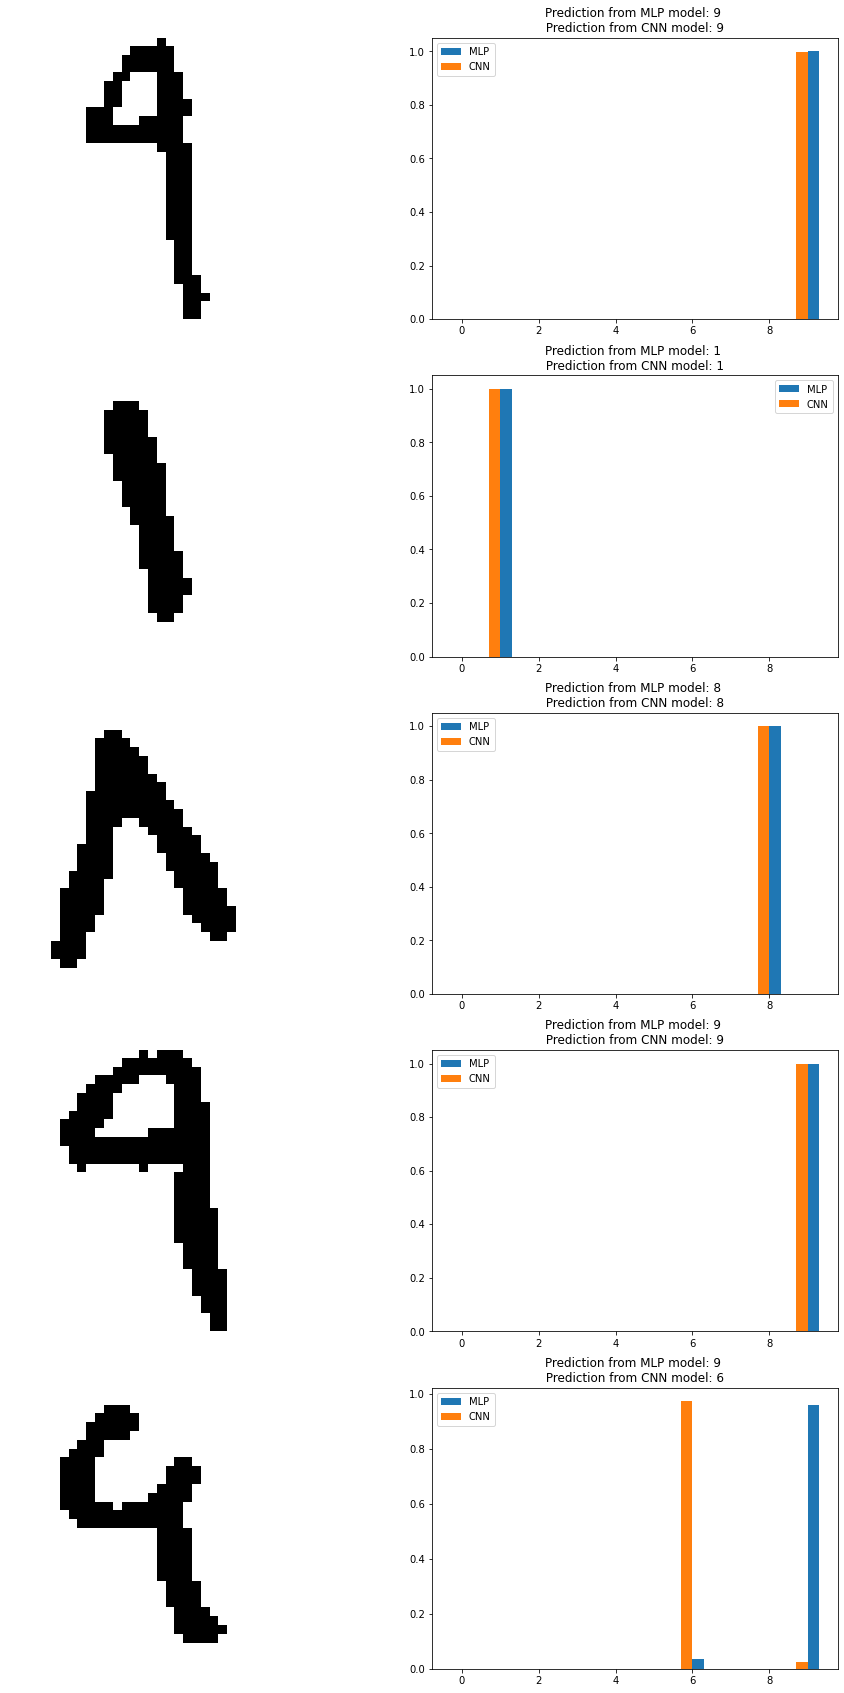

In [22]:
n = 5 # number of random images
show_images_predictions(n,test_images,prediction_MLP, prediction_CNN, cmap='Greys')